In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoProcessor, AutoModel
from PIL import Image
from tqdm import tqdm
from torchcodec.decoders import VideoDecoder

class SigLIPVideoDifferenceAnalyzer:
    def __init__(self, model_name="google/siglip-so400m-patch14-384"):
        print(f"Loading SigLIP model: {model_name}")
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        
        self.model = AutoModel.from_pretrained(model_name, trust_remote_code=True)
        self.processor = AutoProcessor.from_pretrained(model_name, trust_remote_code=True)
        
        self.model.eval()
        self.model.to(self.device)
        print(f"Model loaded on {self.device}")

    def extract_frames(self, video_path, target_fps=1):
        """
        Extract frames from video using torchcodec at a specific frame rate.
        
        Args:
            video_path: Path to the video file
            target_fps: Desired frames per second (e.g., 1 for 1 frame/sec)
        
        Returns:
            frames: List of PIL Images
            native_fps: The original FPS of the video
        """
        print(f"Initializing VideoDecoder for: {video_path}")
        # Note: torchcodec decoder usually stays on CPU for control, 
        # but can decode to GPU memory if specified in get_frames methods
        decoder = VideoDecoder(video_path, device=self.device)
        
        # Get video metadata
        native_fps = decoder.metadata.average_fps
        duration_sec = decoder.metadata.duration_seconds
        total_native_frames = decoder.metadata.num_frames
        
        print(f"Video info: {total_native_frames} frames, {native_fps:.2f} FPS, {duration_sec:.2f}s duration")
        
        if target_fps > native_fps:
            print(f"Warning: Target FPS ({target_fps}) > Native FPS ({native_fps}). Clamping to native.")
            target_fps = native_fps

        # Create a list of timestamps (in seconds) we want to sample
        # e.g., for 1 FPS: 0.0, 1.0, 2.0...
        timestamps = torch.arange(0, duration_sec, 1.0 / target_fps)
        
        print(f"Extracting {len(timestamps)} frames at {target_fps} FPS...")
        
        # Retrieve frames at specific timestamps
        # torchcodec returns data in (N, C, H, W) format, typically uint8
        frame_data = decoder.get_frames_at(timestamps=timestamps).data
        
        # Convert tensors to PIL Images for the SigLIP processor
        # SigLIP processor expects a list of PIL images or numpy arrays
        frames = []
        
        # If the data is on GPU, we need to move it to CPU to convert to PIL
        if frame_data.is_cuda:
            frame_data = frame_data.cpu()
            
        # Iterate and convert
        # torchcodec is usually (Batch, Channels, Height, Width)
        # PIL needs (Height, Width, Channels)
        for i in range(len(frame_data)):
            tensor_img = frame_data[i] # C, H, W
            # Permute to H, W, C
            numpy_img = tensor_img.permute(1, 2, 0).numpy()
            pil_image = Image.fromarray(numpy_img)
            frames.append(pil_image)
            
        print(f"Extracted {len(frames)} frames")
        return frames, native_fps

    def get_frame_embeddings(self, frames, batch_size=2):
        embeddings = []
        print("Computing SigLIP embeddings...")
        
        for i in tqdm(range(0, len(frames), batch_size)):
            batch = frames[i:i + batch_size]
            
            # Process batch
            inputs = self.processor(images=batch, return_tensors="pt", padding=True)
            inputs = {k: v.to(self.device) for k, v in inputs.items()}
            
            with torch.no_grad():
                outputs = self.model.vision_model(**inputs)
                batch_embeddings = outputs.pooler_output
                embeddings.append(batch_embeddings.cpu())
        
        if not embeddings:
            return torch.empty(0)
            
        all_embeddings = torch.cat(embeddings, dim=0)
        return all_embeddings

    def calculate_differences(self, embeddings, metric="cosine"):
        if len(embeddings) < 2:
            return np.array([])
            
        differences = []
        for i in range(len(embeddings) - 1):
            emb1 = embeddings[i]
            emb2 = embeddings[i + 1]
            
            if metric == "cosine":
                cos_sim = torch.nn.functional.cosine_similarity(
                    emb1.unsqueeze(0), emb2.unsqueeze(0)
                )
                diff = 1 - cos_sim.item()
            elif metric == "euclidean":
                diff = torch.dist(emb1, emb2, p=2).item()
            else:
                raise ValueError(f"Unknown metric: {metric}")
            
            differences.append(diff)
        
        return np.array(differences)

    def plot_differences(self, differences, fps, target_fps, 
                        save_path="frame_differences.png", threshold_percentile=90):
        if len(differences) == 0:
            print("No differences to plot.")
            return [], 0.0

        # Time axis is now based on the target_fps we requested
        time_per_sample = 1.0 / target_fps
        time_axis = np.arange(len(differences)) * time_per_sample
        
        threshold = np.percentile(differences, threshold_percentile)
        peaks = np.where(differences > threshold)[0]
        
        plt.figure(figsize=(14, 6))
        
        # Main plot
        plt.subplot(2, 1, 1)
        plt.plot(time_axis, differences, linewidth=1, alpha=0.7)
        plt.scatter(time_axis[peaks], differences[peaks], 
                   color='red', s=50, zorder=5, label=f'Peaks (>{threshold_percentile}th)')
        plt.axhline(y=threshold, color='r', linestyle='--', alpha=0.5, label='Threshold')
        plt.xlabel('Time (seconds)')
        plt.ylabel('Difference')
        plt.title(f'SigLIP Differences (Sampled at {target_fps} FPS)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Histogram
        plt.subplot(2, 1, 2)
        plt.hist(differences, bins=50, alpha=0.7, edgecolor='black')
        plt.axvline(x=threshold, color='r', linestyle='--')
        plt.xlabel('Difference Value')
        plt.ylabel('Frequency')
        
        plt.tight_layout()
        plt.savefig(save_path, dpi=300)
        print(f"Plot saved to: {save_path}")
        plt.show() # Optional if running in notebook
        
        return peaks, threshold

    def analyze_video(self, video_path, target_fps=1, metric="cosine", 
                     save_path="frame_differences.png"):
        """
        Complete pipeline: extract frames at target_fps, compute, and plot.
        """
        # Extract frames
        frames, native_fps = self.extract_frames(video_path, target_fps=target_fps)
        
        if len(frames) < 2:
            raise ValueError("Need at least 2 frames to calculate differences")
        
        # Get embeddings
        embeddings = self.get_frame_embeddings(frames)
        
        # Calculate differences
        print(f"\nCalculating {metric} differences...")
        differences = self.calculate_differences(embeddings, metric)
        
        # Plot
        peaks, threshold = self.plot_differences(differences, native_fps, target_fps, save_path)
        
        return differences, peaks, embeddings

# Example usage
if __name__ == "__main__":
    analyzer = SigLIPVideoDifferenceAnalyzer()
    
    video_path = "/leonardo_work/FAIR_Vision/master-thesis/data/EgoPER/Quesadilla/trim_videos/quesadilla_u1_a1_error_011.mp4"
    
    # Now we simply pass target_fps=1 for one frame per second
    differences, peaks, embeddings = analyzer.analyze_video(
        video_path=video_path,
        target_fps=1,
        metric="cosine",
        save_path="torchcodec_differences.png"
    )

In [1]:
# RUN THIS IN THE VERY FIRST CELL
%env HF_HUB_OFFLINE=1

import os
os.environ["HF_HUB_OFFLINE"] = "1"

print("Offline mode forced.")

env: HF_HUB_OFFLINE=1
Offline mode forced.


In [2]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoProcessor, AutoModel
from PIL import Image
from tqdm import tqdm
import matplotlib.cm as cm
from decord import VideoReader, cpu, gpu
import os
import glob
from PIL import Image


class SigLIPVideoDifferenceAnalyzer:
    def __init__(self, model_name="google/siglip-so400m-patch14-384"):
        import os
        os.environ["HF_HUB_OFFLINE"] = "1"
        
        print(f"Loading SigLIP model: {model_name}")
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.model = AutoModel.from_pretrained(model_name, trust_remote_code=True, local_files_only=True)
        self.processor = AutoProcessor.from_pretrained(model_name, trust_remote_code=True, local_files_only=True)
        self.model.eval()
        self.model.to(self.device)
        print(f"Model loaded on {self.device}")

    def extract_frames(self, video_path, target_fps=1):
        """
        Extract frames using OpenCV at a specific target FPS.
        """
        cap = cv2.VideoCapture(video_path)
        
        native_fps = cap.get(cv2.CAP_PROP_FPS)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        print(f"Native FPS: {native_fps}, Total Frames: {total_frames}")
        
        # Calculate the step size (hop) to achieve target_fps
        # e.g. 30 native / 1 target = 30 (grab every 30th frame)
        if target_fps is None:
            target_fps = native_fps
        step = int(round(native_fps / target_fps))
        if step < 1: step = 1
        
        frames = []
        frame_count = 0
        
        print(f"Video info: {total_frames} frames, {native_fps:.2f} FPS")
        print(f"Targeting {target_fps} FPS -> Extracting every {step} frames")
        
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            
            # Only process if it matches the step
            if frame_count % step == 0:
                frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                pil_image = Image.fromarray(frame_rgb)
                frames.append(pil_image)
            
            frame_count += 1
        
        cap.release()
        print(f"Extracted {len(frames)} frames")
        return frames, native_fps
    
    # import torch
    # from torchcodec.decoders import VideoDecoder

    # def extract_frames_torchcodec(video_path, target_fps=24, device="cuda"):
    #     """
    #     Extracts frames uniformly at a specific target FPS using torchcodec.
    #     Decodes directly to PyTorch tensors on the specified device.
    #     """
    #     # 1. Initialize the decoder (on GPU if available)
    #     decoder = VideoDecoder(video_path, device=device)
        
    #     native_fps = decoder.metadata.average_fps
    #     duration = decoder.metadata.duration_seconds
        
    #     print(f"Video info: {duration:.2f}s, {native_fps:.2f} FPS")
    #     print(f"Targeting {target_fps} FPS using time-based sampling")

    #     # 2. Generate the exact timestamps we want
    #     #    If target_fps=24, we want t=0.0, 0.0416, 0.0833, etc.
    #     step_seconds = 1.0 / target_fps
    #     timestamps = torch.arange(0, duration, step_seconds, dtype=torch.float64)
        
    #     # 3. Retrieve frames in a batch
    #     #    get_frames_played_at automatically finds the nearest frame for each timestamp
    #     frame_batch = decoder.get_frames_played_at(timestamps)
        
    #     # frame_batch.data is a tensor of shape (N, C, H, W)
    #     frames = frame_batch.data
        
    #     print(f"Extracted {len(frames)} frames directly to {frames.device}")
    #     return frames, native_fps

    def extract_frames_decord(self, video_path, target_fps=24, device="cuda"):
        # Select context based on device
        ctx = cpu(0)
        
        # Load video
        vr = VideoReader(video_path, ctx=ctx)
        native_fps = vr.get_avg_fps()
        total_frames = len(vr)
        duration = total_frames / native_fps
        
        # 1. Calculate the indices needed for uniform sampling
        #    We create a timeline of 'target' frames and map them to 'native' indices
        num_target_frames = int(duration * target_fps)
        
        # Linspace generates evenly spaced points from 0 to total_frames
        indices = np.linspace(0, total_frames - 1, num_target_frames).astype(int)
        
        # 2. Batch retrieve frames (decord supports list indexing)
        #    This returns a Tensor (N, H, W, C)
        frames = vr.get_batch(indices)
        
        # 3. Permute to PyTorch standard (N, C, H, W) if needed
        frames = frames.permute(0, 3, 1, 2)
        
        print(f"Extracted {len(frames)} frames")
        return frames, native_fps

    def get_frame_embeddings(self, frames, batch_size=2):
        embeddings = []
        # If no frames were extracted, return empty
        if not frames:
            return torch.empty(0)

        print("Computing SigLIP embeddings...")
        for i in tqdm(range(0, len(frames), batch_size)):
            batch = frames[i:i + batch_size]
            
            inputs = self.processor(images=batch, return_tensors="pt", padding=True)
            inputs = {k: v.to(self.device) for k, v in inputs.items()}
            
            with torch.no_grad():
                outputs = self.model.vision_model(**inputs)
                batch_embeddings = outputs.pooler_output
                embeddings.append(batch_embeddings.cpu())
        
        return torch.cat(embeddings, dim=0)

    def calculate_differences(self, embeddings, metric="cosine"):
        if len(embeddings) < 2:
            return np.array([])
            
        differences = []
        for i in range(len(embeddings) - 1):
            emb1 = embeddings[i]
            emb2 = embeddings[i + 1]
            
            if metric == "cosine":
                cos_sim = torch.nn.functional.cosine_similarity(
                    emb1.unsqueeze(0), emb2.unsqueeze(0)
                )
                diff = 1 - cos_sim.item()
            elif metric == "euclidean":
                diff = torch.dist(emb1, emb2, p=2).item()
            else:
                raise ValueError(f"Unknown metric: {metric}")
            
            differences.append(diff)
        
        return np.array(differences)


    def plot_differences_with_annotations(self, differences, target_fps, 
                                        annotations=None, 
                                        peaks=None,  # indices of detected peaks
                                        save_path=None):
        
        # Ensure differences is a numpy array for easy indexing
        if not isinstance(differences, np.ndarray):
            if hasattr(differences, 'cpu'):
                differences = differences.detach().cpu().numpy()
            else:
                differences = np.array(differences)

        if len(differences) == 0:
            print("No data to plot")
            return [], 0.0

        # Time axis
        time_per_sample = 1.0 / target_fps
        time_axis = np.arange(len(differences)) * time_per_sample

        # Plot only the line plot
        plt.figure(figsize=(14, 4))
        plt.plot(time_axis, differences, linewidth=1, alpha=0.7, label="Frame Differences")

        # --- 2. Plot Peaks (Red 'x') ---
        if peaks is not None and len(peaks) > 0:
            # We use the peak indices to grab the corresponding Time and Difference values
            peak_times = time_axis[peaks]
            peak_values = differences[peaks]
            
            plt.plot(peak_times, peak_values, "x", color='red', markersize=8, 
                    markeredgewidth=2, label="Detected Peaks")
        # -------------------------------

        # Plot annotations if provided
        if annotations is not None:
            num_annotators = len(annotations)
            # using plt.get_cmap to avoid deprecated cm.get_cmap in newer matplotlib versions
            cmap = plt.get_cmap('tab10') 
            
            for i, annotator_times in enumerate(annotations):
                color = cmap(i % 10) # Safety modulo
                for ts in annotator_times:
                    plt.axvline(x=ts, color=color, linestyle='--', alpha=0.7,
                                label=f'Annotator {i+1}' if ts == annotator_times[0] else "")

        plt.xlabel('Time (seconds)')
        plt.ylabel('Difference')
        plt.title(f'Frame Differences (Sampled at {target_fps} FPS)')
        plt.legend()
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=300)
            print(f"Plot saved to: {save_path}")
        plt.show()

        return None
        
    def analyze_video(self, video_path, target_fps=1, metric="cosine", 
                     save_path="frame_differences.png"):
        
        frames, native_fps = self.extract_frames(video_path, target_fps=target_fps)
        
        if len(frames) < 2:
            raise ValueError("Need at least 2 frames")
        
        embeddings = self.get_frame_embeddings(frames)
        differences = self.calculate_differences(embeddings, metric)
        peaks, threshold = self.plot_differences(differences, target_fps, save_path)
        
        return differences, peaks, embeddings
        

    def find_high_difference_timestamps(self, differences, fps, percentile=95):
        """
        Find timestamps (in seconds) where frame-to-frame difference
        exceeds a given percentile threshold.

        Args:
            differences (np.ndarray): Shape (N-1,), frame-to-frame differences
            fps (float): Sampling FPS used when extracting frames
            percentile (float): Percentile threshold (default: 95)

        Returns:
            timestamps (np.ndarray): Times (seconds) where difference is high
            threshold (float): The percentile threshold value
            indices (np.ndarray): Indices of detected high-difference frames
        """
        if len(differences) == 0:
            return np.array([]), None, np.array([])

        # Compute percentile threshold
        threshold = np.percentile(differences, percentile)

        # Indices where difference exceeds threshold
        indices = np.where(differences > threshold)[0]

        # Convert indices to timestamps (seconds)
        # difference[i] corresponds to transition at time i / fps
        timestamps = indices / fps

        return timestamps, threshold, indices


    def load_frames_from_folder(self, folder_path):
        """
        Loads all frames directly from a folder of images.
        
        Args:
            folder_path (str): Path to the folder containing frame images.
        
        Returns:
            List[PIL.Image]: A list of loaded PIL images.
        """
        # 1. Find all image files (jpg, png, jpeg)
        extensions = ['*.jpg', '*.jpeg', '*.png']
        image_paths = []
        
        for ext in extensions:
            image_paths.extend(glob.glob(os.path.join(folder_path, ext)))
        
        # 2. Sort naturally to ensure temporal order
        image_paths.sort()

        print("found", image_paths)

        if not image_paths:
            print(f"[WARN] No images found in {folder_path}")
            return []

        print(f"Folder: {os.path.basename(folder_path)} | Loading all {len(image_paths)} frames")

        # 3. Load images
        frames = []
        for path in image_paths:
            try:
                # .convert("RGB") handles PNGs with alpha channels or grayscale JPEGs
                img = Image.open(path).convert("RGB")
                frames.append(img)
            except Exception as e:
                print(f"[ERROR] Could not load {path}: {e}")

        return frames

/leonardo/home/userexternal/lzhou001/miniconda3/envs/torch312/lib/python3.12/site-packages/transformers/utils/hub.py:110: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
2026-01-21 11:02:46.608798: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-21 11:02:47.511933: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
analyzer = SigLIPVideoDifferenceAnalyzer()

Loading SigLIP model: google/siglip-so400m-patch14-384


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Model loaded on cuda


In [30]:
def load_gt_annotation_timestamps(gt_annotation_path, VIDEO_PATH):
    # Extract video_id from VIDEO_PATH
    import os
    import json

    # Extract video_id (remove the frame range part)
    video_id = os.path.splitext(os.path.basename(VIDEO_PATH))[0].split('_')[0]
    print("Video ID:", video_id)  # Output: -15OAjLm520

    # Load the JSON annotations
    with open(gt_annotation_path, 'r') as f:
        annotations = json.load(f)

    # Search for the matching entry
    video_entry = annotations.get(video_id)

    if video_entry:
        print("Found entry for video:", video_entry)
    else:
        print("No entry found for video_id:", video_id)

    annots_timestamps = video_entry["substages_timestamps"]
    return annots_timestamps

In [ ]:
gt_annotation_path ="data/Kinetics-GEBD/prepared_gt/k400_mr345_val_min_change_duration0.3.json"
VIDEO_PATH = "data/Kinetics-GEBD/kinetics-dataset/k400/val/-15UpGVyV4w_000001_000011.mp4"

In [8]:
# Extract video_id from VIDEO_PATH
import os
import json

# Extract video_id (remove the frame range part)
video_id = os.path.splitext(os.path.basename(VIDEO_PATH))[0].split('_')[0]
print("Video ID:", video_id)  # Output: -15OAjLm520

# Load the JSON annotations
with open(gt_annotation_path, 'r') as f:
    annotations = json.load(f)

# Search for the matching entry
video_entry = annotations.get(video_id)

if video_entry:
    print("Found entry for video:", video_entry)
else:
    print("No entry found for video_id:", video_id)

annots_timestamps = video_entry["substages_timestamps"]

Video ID: -15UpGVyV4w
Found entry for video: {'f1_consis': [0.63055555555556, 0.64958513708514, 0.51857142857143, 0.60742424242424, 0.43529942279942], 'f1_consis_avg': 0.568287157287158, 'fps': 29.97002997002997, 'num_frames': 199, 'path_frame': 'feeding_fish/-15UpGVyV4w_000001_000011', 'path_video': 'feeding_fish/-15UpGVyV4w_000001_000011.mp4', 'substages_myframeidx': [[41.0, 76.0, 124.0, 148.0], [41.0, 94.0, 129.0, 149.0], [52.0, 90.0, 162.0], [20.0, 46.0, 80.0, 134.0, 158.0, 178.0], [83.0, 125.0]], 'substages_timestamps': [[1.37761, 2.54424, 4.16469, 4.94891], [1.37748, 3.16672, 4.33576, 5.00099], [1.74131, 3.01437, 5.407], [0.69243, 1.55374, 2.68705, 4.50034, 5.2969, 5.9445], [2.78859, 4.17922]], 'video_duration': 6.639966666666667}


In [24]:
TARGET_FPS = None
#VIDEO_PATH = "kinetics-dataset/k400/val/-15OAjLm520_000006_000016.mp4"
VIDEO_PATH = "data/Kinetics-GEBD/kinetics-dataset/k400/val/-15UpGVyV4w_000001_000011.mp4"
annots_timestamps = load_gt_annotation_timestamps(gt_annotation_path, VIDEO_PATH)
frames, native_fps = analyzer.extract_frames(VIDEO_PATH, target_fps=TARGET_FPS)
embeddings = analyzer.get_frame_embeddings(frames)

differences = analyzer.calculate_differences(embeddings)

Video ID: -15UpGVyV4w
Found entry for video: {'f1_consis': [0.63055555555556, 0.64958513708514, 0.51857142857143, 0.60742424242424, 0.43529942279942], 'f1_consis_avg': 0.568287157287158, 'fps': 29.97002997002997, 'num_frames': 199, 'path_frame': 'feeding_fish/-15UpGVyV4w_000001_000011', 'path_video': 'feeding_fish/-15UpGVyV4w_000001_000011.mp4', 'substages_myframeidx': [[41.0, 76.0, 124.0, 148.0], [41.0, 94.0, 129.0, 149.0], [52.0, 90.0, 162.0], [20.0, 46.0, 80.0, 134.0, 158.0, 178.0], [83.0, 125.0]], 'substages_timestamps': [[1.37761, 2.54424, 4.16469, 4.94891], [1.37748, 3.16672, 4.33576, 5.00099], [1.74131, 3.01437, 5.407], [0.69243, 1.55374, 2.68705, 4.50034, 5.2969, 5.9445], [2.78859, 4.17922]], 'video_duration': 6.639966666666667}
Native FPS: 29.97002997002997, Total Frames: 199
Video info: 199 frames, 29.97 FPS
Targeting 29.97002997002997 FPS -> Extracting every 1 frames
Extracted 199 frames
Computing SigLIP embeddings...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.96it/s]


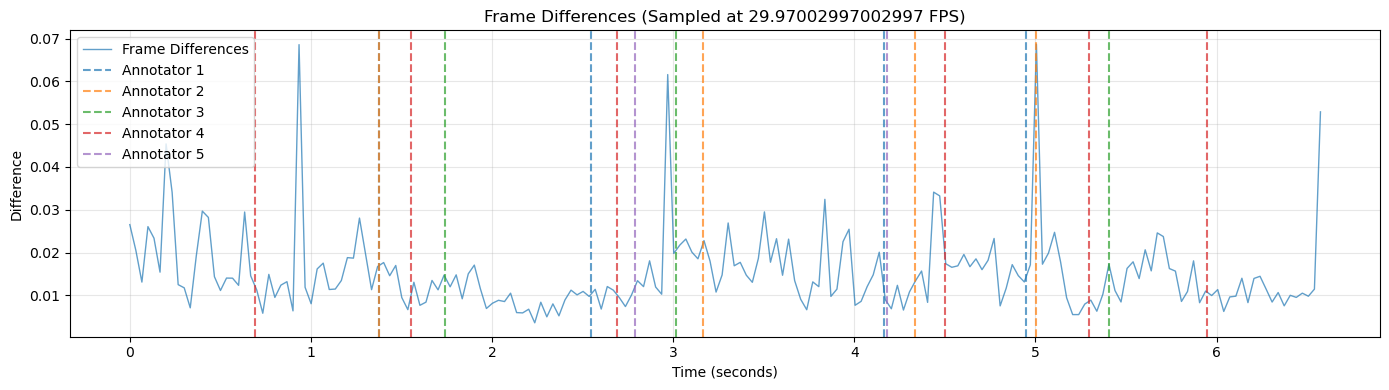

In [25]:
analyzer.plot_differences_with_annotations(differences, native_fps,
                                          annotations=annots_timestamps,
                                          save_path=None)

In [26]:
from scipy.signal import find_peaks

# 1. Ensure data is on CPU and is a numpy array
#    (Assuming 'differences' might be a torch.Tensor on CUDA)
if hasattr(differences, 'cpu'):
    signal = differences.detach().cpu().numpy()
else:
    signal = np.array(differences)

# 2. Flatten if necessary (ensure it's 1D)
signal = signal.flatten()

# 3. Find Peaks
#    height: Minimum value to be considered a peak (filters low-level noise)
#    distance: Min frames between peaks (prevents detecting the same cut twice)
#    prominence: How much a peak stands out relative to the surrounding baseline
peaks, properties = find_peaks(
    signal, 
    #height=0.1,      # Adjust based on your embedding metric (e.g., Cosine vs Euclidean)
    distance=5,      # E.g., assume cuts won't happen closer than 5 frames apart
    prominence=0.05  # Helps ignore "noisy" high areas
)

# Calculate timestamps of the detected boundaries
detected_timestamps = peaks / native_fps
print("Timestamps (seconds):", detected_timestamps)


print(f"Detected {len(peaks)} boundaries at frame indices: {peaks}, Timestamps (s): {detected_timestamps}")

Timestamps (seconds): [0.93426667 2.96963333 5.005     ]
Detected 3 boundaries at frame indices: [ 28  89 150], Timestamps (s): [0.93426667 2.96963333 5.005     ]


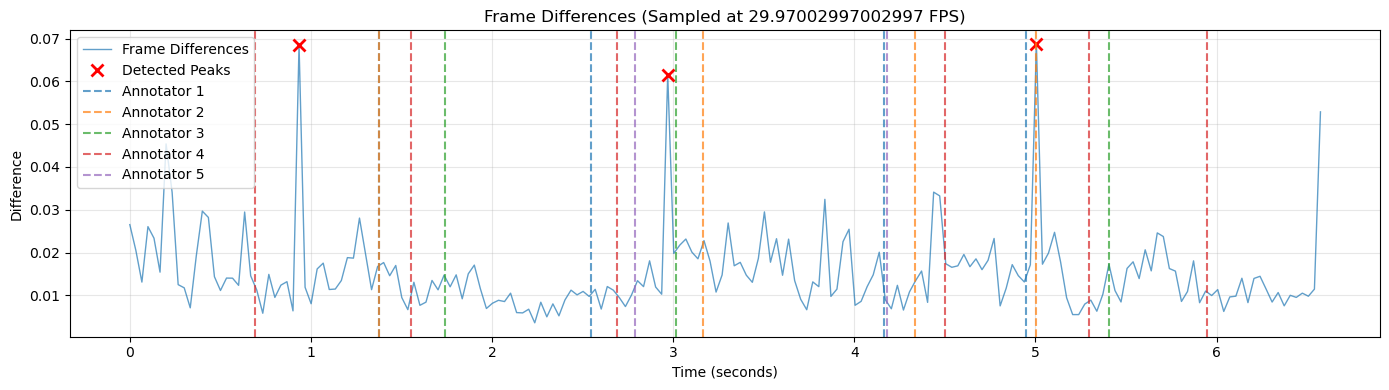

In [27]:
analyzer.plot_differences_with_annotations(differences, native_fps,
                                            annotations=annots_timestamps,
                                            peaks=peaks,
                                            save_path=None)

Video ID: -15UpGVyV4w
Found entry for video: {'f1_consis': [0.63055555555556, 0.64958513708514, 0.51857142857143, 0.60742424242424, 0.43529942279942], 'f1_consis_avg': 0.568287157287158, 'fps': 29.97002997002997, 'num_frames': 199, 'path_frame': 'feeding_fish/-15UpGVyV4w_000001_000011', 'path_video': 'feeding_fish/-15UpGVyV4w_000001_000011.mp4', 'substages_myframeidx': [[41.0, 76.0, 124.0, 148.0], [41.0, 94.0, 129.0, 149.0], [52.0, 90.0, 162.0], [20.0, 46.0, 80.0, 134.0, 158.0, 178.0], [83.0, 125.0]], 'substages_timestamps': [[1.37761, 2.54424, 4.16469, 4.94891], [1.37748, 3.16672, 4.33576, 5.00099], [1.74131, 3.01437, 5.407], [0.69243, 1.55374, 2.68705, 4.50034, 5.2969, 5.9445], [2.78859, 4.17922]], 'video_duration': 6.639966666666667}
Native FPS: 29.97002997002997, Total Frames: 199
Video info: 199 frames, 29.97 FPS
Targeting 10 FPS -> Extracting every 3 frames
Extracted 67 frames
Computing SigLIP embeddings...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.05it/s]
/tmp/ipykernel_4145236/224707516.py:230: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10', num_annotators)  # up to 10 colors


Plot saved to: differences_with_annotations.png


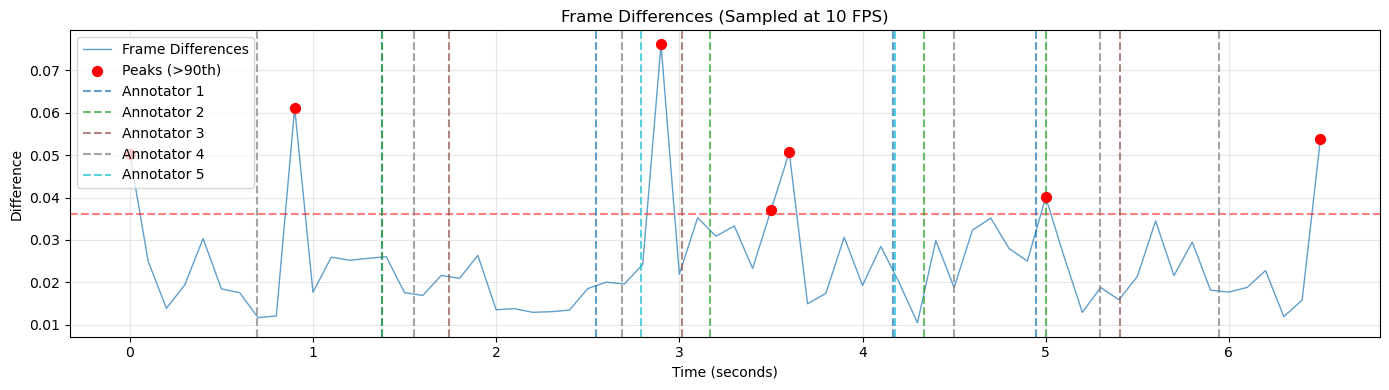

(array([ 0,  9, 29, 35, 36, 50, 65]), np.float64(0.03611433506011963))

In [ ]:
TARGET_FPS = 10
#VIDEO_PATH = "kinetics-dataset/k400/val/-15OAjLm520_000006_000016.mp4"
VIDEO_PATH = "data/Kinetics-GEBD/kinetics-dataset/k400/val/-15UpGVyV4w_000001_000011.mp4"
annots_timestamps = load_gt_annotation_timestamps(gt_annotation_path, VIDEO_PATH)
frames, native_fps = analyzer.extract_frames(VIDEO_PATH, target_fps=TARGET_FPS)
embeddings = analyzer.get_frame_embeddings(frames)

# 2. Check the first few values to see them manually
differences = analyzer.calculate_differences(embeddings)
analyzer.plot_differences_with_annotations(differences, TARGET_FPS,
                                          annotations=annots_timestamps,
                                          save_path="differences_with_annotations.png")

test metrics

In [28]:
analyzer = SigLIPVideoDifferenceAnalyzer()

Loading SigLIP model: google/siglip-so400m-patch14-384
Model loaded on cuda


In [29]:
pred_dict = {}

In [30]:
TARGET_FPS = None
#VIDEO_PATH = "kinetics-dataset/k400/val/-15OAjLm520_000006_000016.mp4"
VIDEO_PATH = "data/Kinetics-GEBD/kinetics-dataset/k400/val/-15UpGVyV4w_000001_000011.mp4"
video_id = os.path.splitext(os.path.basename(VIDEO_PATH))[0].split('_')[0]
frames, native_fps = analyzer.extract_frames(VIDEO_PATH, target_fps=TARGET_FPS)
embeddings = analyzer.get_frame_embeddings(frames)

# 2. Check the first few values to see them manually
differences = analyzer.calculate_differences(embeddings)

peaks, properties = find_peaks(
    signal, 
    #height=0.1,      # Adjust based on your embedding metric (e.g., Cosine vs Euclidean)
    distance=5,      # E.g., assume cuts won't happen closer than 5 frames apart
    prominence=0.05  # Helps ignore "noisy" high areas
)

# Calculate timestamps of the detected boundaries
detected_timestamps = peaks / native_fps


pred_dict[video_id] = detected_timestamps.tolist()

Native FPS: 29.97002997002997, Total Frames: 199
Video info: 199 frames, 29.97 FPS
Targeting 29.97002997002997 FPS -> Extracting every 1 frames
Extracted 199 frames
Computing SigLIP embeddings...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.93it/s]


Video ID: -15UpGVyV4w
Found entry for video: {'f1_consis': [0.63055555555556, 0.64958513708514, 0.51857142857143, 0.60742424242424, 0.43529942279942], 'f1_consis_avg': 0.568287157287158, 'fps': 29.97002997002997, 'num_frames': 199, 'path_frame': 'feeding_fish/-15UpGVyV4w_000001_000011', 'path_video': 'feeding_fish/-15UpGVyV4w_000001_000011.mp4', 'substages_myframeidx': [[41.0, 76.0, 124.0, 148.0], [41.0, 94.0, 129.0, 149.0], [52.0, 90.0, 162.0], [20.0, 46.0, 80.0, 134.0, 158.0, 178.0], [83.0, 125.0]], 'substages_timestamps': [[1.37761, 2.54424, 4.16469, 4.94891], [1.37748, 3.16672, 4.33576, 5.00099], [1.74131, 3.01437, 5.407], [0.69243, 1.55374, 2.68705, 4.50034, 5.2969, 5.9445], [2.78859, 4.17922]], 'video_duration': 6.639966666666667}
Plot saved to: differences_with_annotations.png


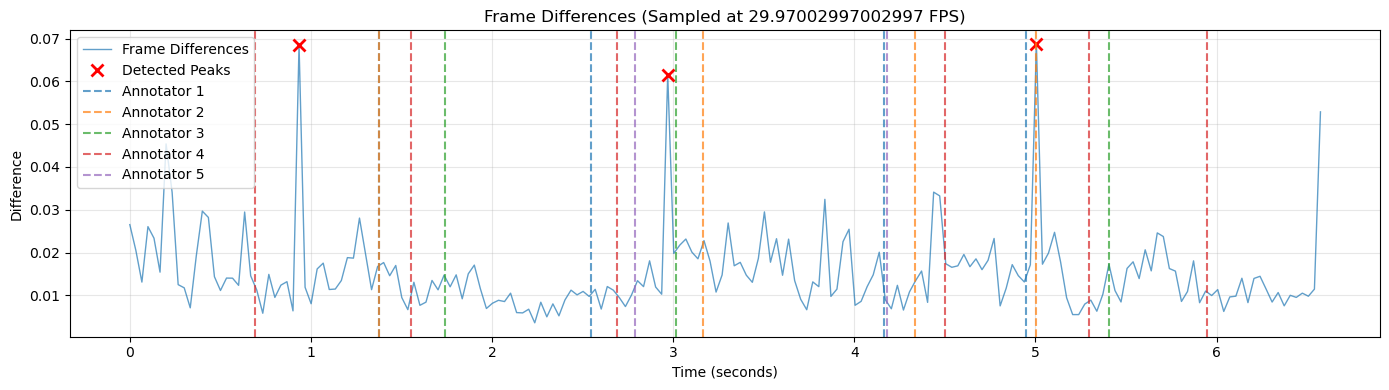

In [31]:
annots_timestamps = load_gt_annotation_timestamps(gt_annotation_path, VIDEO_PATH)
analyzer.plot_differences_with_annotations(differences, native_fps,
                                          annotations=annots_timestamps,
                                          peaks=peaks,
                                          save_path="differences_with_annotations.png")

In [32]:
import json
gt_annotation_path ="data/Kinetics-GEBD/prepared_gt/k400_mr345_val_min_change_duration0.3.json"
with open(gt_annotation_path, 'r') as f:
    gt_annotations = json.load(f)

In [33]:
gt_annotations

{'--07WQ2iBlw': {'f1_consis': [0.72571428571429,
   0.70404761904762,
   0.65880952380952,
   0.67857142857143,
   0.66],
  'f1_consis_avg': 0.685428571428572,
  'fps': 29.97002997002997,
  'num_frames': 273,
  'path_frame': 'javelin_throw/--07WQ2iBlw_000001_000011',
  'path_video': 'javelin_throw/--07WQ2iBlw_000001_000011.mp4',
  'substages_myframeidx': [[15.0, 50.0, 93.0, 127.0, 160.0, 206.0],
   [15.0, 62.0, 101.0, 122.0, 195.0, 238.0],
   [14.0, 71.0, 104.0, 194.0],
   [12.0, 35.0, 72.0, 102.0, 125.0, 151.0, 201.0, 220.0],
   [12.0, 90.0, 124.0]],
  'substages_timestamps': [[0.52334,
    1.6713550000000001,
    3.129415,
    4.2376,
    5.3715,
    6.89196],
   [0.50809, 2.06962, 3.39754, 4.09838, 6.5329, 7.97148],
   [0.47548, 2.399015, 3.47245, 6.48383],
   [0.40475, 1.17534, 2.40517, 3.42483, 4.17207, 5.05941, 6.72512, 7.34782],
   [0.40605, 3.0340800000000003, 4.15071]],
  'video_duration': 9.1091},
 '--33Lscn6sk': {'f1_consis': [0.39904761904762,
   0.53355477855478,
   0.6217

In [34]:
from eval import evaluate_gebd, do_eval
results = {}
rel_dis_thres = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
for thres in rel_dis_thres:
    res = []
    f1, rec, prec = do_eval(gt_annotations, pred_dict, threshold=thres)
    res.append((f1, rec, prec))
    results[thres] = res

In [35]:
results

{0.05: [(0, np.float64(0.0), np.float64(0.0))],
 0.1: [(np.float64(0.2222222222222222),
   np.float64(0.16666666666666666),
   np.float64(0.3333333333333333))],
 0.15: [(np.float64(0.2222222222222222),
   np.float64(0.16666666666666666),
   np.float64(0.3333333333333333))],
 0.2: [(np.float64(0.28571428571428575),
   np.float64(0.25),
   np.float64(0.3333333333333333))],
 0.25: [(np.float64(0.4444444444444444),
   np.float64(0.3333333333333333),
   np.float64(0.6666666666666666))],
 0.3: [(np.float64(0.4444444444444444),
   np.float64(0.3333333333333333),
   np.float64(0.6666666666666666))],
 0.35: [(np.float64(0.4444444444444444),
   np.float64(0.3333333333333333),
   np.float64(0.6666666666666666))],
 0.4: [(np.float64(0.6666666666666666), np.float64(0.5), np.float64(1.0))],
 0.45: [(np.float64(0.6666666666666666),
   np.float64(0.6666666666666666),
   np.float64(0.6666666666666666))],
 0.5: [(np.float64(0.6666666666666666),
   np.float64(0.6666666666666666),
   np.float64(0.66666666

In [42]:
import os
from tqdm import tqdm

VIDEO_DIR = "data/Kinetics-GEBD/kinetics-dataset/k400/val"
TARGET_FPS = None
PERCENTILE = 90
MAX_VIDEOS = 30  # Set to None to process all videos

video_paths = sorted([
    os.path.join(VIDEO_DIR, f)
    for f in os.listdir(VIDEO_DIR)
    if f.endswith(".mp4")
])

# Limit number of videos if requested
if MAX_VIDEOS is not None:
    video_paths = video_paths[:MAX_VIDEOS]

pred_dict = {}

for video_path in tqdm(video_paths, desc="Processing videos"):
    video_id = os.path.splitext(os.path.basename(video_path))[0].split('_')[0]

    try:
        frames, native_fps = analyzer.extract_frames(
            video_path,
            target_fps=TARGET_FPS
        )

        embeddings = analyzer.get_frame_embeddings(frames)
        differences = analyzer.calculate_differences(embeddings)

        timestamps, threshold, indices = analyzer.find_high_difference_timestamps(
            differences,
            fps=native_fps,
            percentile=PERCENTILE
        )

        pred_dict[video_id] = timestamps.tolist()

    except Exception as e:
        print(f"[ERROR] {video_id}: {e}")
        pred_dict[video_id] = []

Processing videos:   0%|                                                                                                       | 0/30 [00:00<?, ?it/s]

Native FPS: 29.97002997002997, Total Frames: 273
Video info: 273 frames, 29.97 FPS
Targeting 29.97002997002997 FPS -> Extracting every 1 frames
Extracted 273 frames
Computing SigLIP embeddings...


Processing videos:   3%|███▏                                                                                           | 1/30 [00:16<08:03, 16.67s/it]

Native FPS: 30.0, Total Frames: 191
Video info: 191 frames, 30.00 FPS
Targeting 30.0 FPS -> Extracting every 1 frames
Extracted 191 frames
Computing SigLIP embeddings...


Processing videos:   7%|██████▎                                                                                        | 2/30 [00:26<05:55, 12.68s/it]

Native FPS: 13.372, Total Frames: 104
Video info: 104 frames, 13.37 FPS
Targeting 13.372 FPS -> Extracting every 1 frames
Extracted 104 frames
Computing SigLIP embeddings...


Processing videos:  10%|█████████▌                                                                                     | 3/30 [00:31<04:11,  9.30s/it]

Native FPS: 30.0, Total Frames: 300
Video info: 300 frames, 30.00 FPS
Targeting 30.0 FPS -> Extracting every 1 frames
Extracted 300 frames
Computing SigLIP embeddings...


Processing videos:  13%|████████████▋                                                                                  | 4/30 [00:47<05:05, 11.76s/it]

Native FPS: 25.0, Total Frames: 250
Video info: 250 frames, 25.00 FPS
Targeting 25.0 FPS -> Extracting every 1 frames
Extracted 250 frames
Computing SigLIP embeddings...


Processing videos:  17%|███████████████▊                                                                               | 5/30 [00:59<05:01, 12.04s/it]

Native FPS: 30.0, Total Frames: 300
Video info: 300 frames, 30.00 FPS
Targeting 30.0 FPS -> Extracting every 1 frames
Extracted 300 frames
Computing SigLIP embeddings...


Processing videos:  20%|███████████████████                                                                            | 6/30 [01:15<05:15, 13.14s/it]

Native FPS: 15.0, Total Frames: 150
Video info: 150 frames, 15.00 FPS
Targeting 15.0 FPS -> Extracting every 1 frames
Extracted 150 frames
Computing SigLIP embeddings...


Processing videos:  23%|██████████████████████▏                                                                        | 7/30 [01:22<04:19, 11.28s/it]

Native FPS: 30.0, Total Frames: 300
Video info: 300 frames, 30.00 FPS
Targeting 30.0 FPS -> Extracting every 1 frames
Extracted 300 frames
Computing SigLIP embeddings...


Processing videos:  27%|█████████████████████████▎                                                                     | 8/30 [01:40<04:55, 13.41s/it]

Native FPS: 29.97002997002997, Total Frames: 300
Video info: 300 frames, 29.97 FPS
Targeting 29.97002997002997 FPS -> Extracting every 1 frames
Extracted 300 frames
Computing SigLIP embeddings...


Processing videos:  30%|████████████████████████████▌                                                                  | 9/30 [01:56<04:56, 14.14s/it]

Native FPS: 29.97002997002997, Total Frames: 300
Video info: 300 frames, 29.97 FPS
Targeting 29.97002997002997 FPS -> Extracting every 1 frames
Extracted 300 frames
Computing SigLIP embeddings...


Processing videos:  33%|███████████████████████████████▎                                                              | 10/30 [02:12<04:53, 14.66s/it]

Native FPS: 15.0, Total Frames: 69
Video info: 69 frames, 15.00 FPS
Targeting 15.0 FPS -> Extracting every 1 frames
Extracted 69 frames
Computing SigLIP embeddings...


Processing videos:  37%|██████████████████████████████████▍                                                           | 11/30 [02:15<03:33, 11.24s/it]

Native FPS: 25.0, Total Frames: 250
Video info: 250 frames, 25.00 FPS
Targeting 25.0 FPS -> Extracting every 1 frames
Extracted 250 frames
Computing SigLIP embeddings...


Processing videos:  40%|█████████████████████████████████████▌                                                        | 12/30 [02:28<03:31, 11.77s/it]

Native FPS: 29.97002997002997, Total Frames: 300
Video info: 300 frames, 29.97 FPS
Targeting 29.97002997002997 FPS -> Extracting every 1 frames
Extracted 300 frames
Computing SigLIP embeddings...


Processing videos:  43%|████████████████████████████████████████▋                                                     | 13/30 [02:44<03:39, 12.94s/it]

Native FPS: 15.0, Total Frames: 128
Video info: 128 frames, 15.00 FPS
Targeting 15.0 FPS -> Extracting every 1 frames
Extracted 128 frames
Computing SigLIP embeddings...


Processing videos:  47%|███████████████████████████████████████████▊                                                  | 14/30 [02:50<02:56, 11.06s/it]

Native FPS: 25.0, Total Frames: 250
Video info: 250 frames, 25.00 FPS
Targeting 25.0 FPS -> Extracting every 1 frames
Extracted 250 frames
Computing SigLIP embeddings...


Processing videos:  50%|███████████████████████████████████████████████                                               | 15/30 [03:06<03:04, 12.33s/it]

Native FPS: 29.97002997002997, Total Frames: 300
Video info: 300 frames, 29.97 FPS
Targeting 29.97002997002997 FPS -> Extracting every 1 frames
Extracted 300 frames
Computing SigLIP embeddings...


Processing videos:  53%|██████████████████████████████████████████████████▏                                           | 16/30 [03:22<03:07, 13.36s/it]

Native FPS: 29.97002997002997, Total Frames: 300
Video info: 300 frames, 29.97 FPS
Targeting 29.97002997002997 FPS -> Extracting every 1 frames
Extracted 300 frames
Computing SigLIP embeddings...


Processing videos:  57%|█████████████████████████████████████████████████████▎                                        | 17/30 [03:40<03:12, 14.81s/it]

Native FPS: 29.97002997002997, Total Frames: 300
Video info: 300 frames, 29.97 FPS
Targeting 29.97002997002997 FPS -> Extracting every 1 frames
Extracted 300 frames
Computing SigLIP embeddings...


Processing videos:  60%|████████████████████████████████████████████████████████▍                                     | 18/30 [03:58<03:09, 15.79s/it]

Native FPS: 25.0, Total Frames: 250
Video info: 250 frames, 25.00 FPS
Targeting 25.0 FPS -> Extracting every 1 frames
Extracted 250 frames
Computing SigLIP embeddings...


Processing videos:  63%|███████████████████████████████████████████████████████████▌                                  | 19/30 [04:13<02:51, 15.59s/it]

Native FPS: 30.0, Total Frames: 300
Video info: 300 frames, 30.00 FPS
Targeting 30.0 FPS -> Extracting every 1 frames
Extracted 300 frames
Computing SigLIP embeddings...


Processing videos:  67%|██████████████████████████████████████████████████████████████▋                               | 20/30 [04:31<02:44, 16.41s/it]

Native FPS: 25.0, Total Frames: 250
Video info: 250 frames, 25.00 FPS
Targeting 25.0 FPS -> Extracting every 1 frames
Extracted 250 frames
Computing SigLIP embeddings...


Processing videos:  70%|█████████████████████████████████████████████████████████████████▊                            | 21/30 [04:44<02:18, 15.38s/it]

Native FPS: 29.791459781529294, Total Frames: 298
Video info: 298 frames, 29.79 FPS
Targeting 29.791459781529294 FPS -> Extracting every 1 frames
Extracted 298 frames
Computing SigLIP embeddings...


Processing videos:  73%|████████████████████████████████████████████████████████████████████▉                         | 22/30 [05:00<02:04, 15.62s/it]

Native FPS: 30.0, Total Frames: 300
Video info: 300 frames, 30.00 FPS
Targeting 30.0 FPS -> Extracting every 1 frames
Extracted 300 frames
Computing SigLIP embeddings...


Processing videos:  77%|████████████████████████████████████████████████████████████████████████                      | 23/30 [05:19<01:54, 16.41s/it]

Native FPS: 30.0, Total Frames: 300
Video info: 300 frames, 30.00 FPS
Targeting 30.0 FPS -> Extracting every 1 frames
Extracted 300 frames
Computing SigLIP embeddings...


Processing videos:  80%|███████████████████████████████████████████████████████████████████████████▏                  | 24/30 [05:37<01:41, 16.98s/it]

Native FPS: 30.0, Total Frames: 75
Video info: 75 frames, 30.00 FPS
Targeting 30.0 FPS -> Extracting every 1 frames
Extracted 75 frames
Computing SigLIP embeddings...


Processing videos:  83%|██████████████████████████████████████████████████████████████████████████████▎               | 25/30 [05:42<01:06, 13.27s/it]

Native FPS: 29.97002997002997, Total Frames: 300
Video info: 300 frames, 29.97 FPS
Targeting 29.97002997002997 FPS -> Extracting every 1 frames
Extracted 300 frames
Computing SigLIP embeddings...


Processing videos:  87%|█████████████████████████████████████████████████████████████████████████████████▍            | 26/30 [06:00<00:59, 14.75s/it]

Native FPS: 15.0, Total Frames: 150
Video info: 150 frames, 15.00 FPS
Targeting 15.0 FPS -> Extracting every 1 frames
Extracted 150 frames
Computing SigLIP embeddings...


Processing videos:  90%|████████████████████████████████████████████████████████████████████████████████████▌         | 27/30 [06:08<00:38, 12.68s/it]

Native FPS: 29.97002997002997, Total Frames: 300
Video info: 300 frames, 29.97 FPS
Targeting 29.97002997002997 FPS -> Extracting every 1 frames
Extracted 300 frames
Computing SigLIP embeddings...


Processing videos:  93%|███████████████████████████████████████████████████████████████████████████████████████▋      | 28/30 [06:23<00:27, 13.56s/it]

Native FPS: 29.97002997002997, Total Frames: 300
Video info: 300 frames, 29.97 FPS
Targeting 29.97002997002997 FPS -> Extracting every 1 frames
Extracted 300 frames
Computing SigLIP embeddings...


Processing videos:  97%|██████████████████████████████████████████████████████████████████████████████████████████▊   | 29/30 [06:39<00:14, 14.15s/it]

Native FPS: 30.0, Total Frames: 300
Video info: 300 frames, 30.00 FPS
Targeting 30.0 FPS -> Extracting every 1 frames
Extracted 300 frames
Computing SigLIP embeddings...


Processing videos: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [06:57<00:00, 13.92s/it]


In [39]:
differences

array([4.13715839e-04, 9.35494900e-03, 4.04715538e-05, 5.28973341e-03,
       1.12175941e-04, 6.94990158e-05, 6.73156977e-03, 7.32201338e-03,
       5.65648079e-05, 5.02991676e-03, 4.45246696e-05, 6.34491444e-03,
       2.02059746e-05, 4.52196598e-03, 1.92523003e-05, 3.88294458e-03,
       6.43336773e-03, 2.65240669e-05, 9.05728340e-03, 1.05143785e-02,
       4.65428829e-03, 1.09672546e-04, 5.77718019e-03, 6.37453794e-03,
       5.34605980e-03, 5.94568253e-03, 1.33361816e-02, 1.16231441e-02,
       1.64846778e-02, 9.48095322e-03, 7.52329826e-03, 9.41717625e-03,
       7.39955902e-03, 1.44575834e-02, 1.00899935e-02, 4.36306000e-05,
       2.47043967e-02, 1.03965402e-02, 4.96506691e-05, 1.24400854e-02,
       8.73714685e-03, 5.94854355e-05, 1.28183961e-02, 1.27553940e-04,
       1.42983794e-02, 3.25143337e-04, 1.38619542e-02, 2.23815441e-04,
       1.64376497e-02, 2.87294388e-05, 1.37805343e-02, 2.34603882e-04,
       6.17235899e-03, 1.30057335e-04, 1.32471919e-02, 1.27136707e-04,
      

In [40]:
import os
from tqdm import tqdm

VIDEO_DIR = "data/Kinetics-GEBD/kinetics-dataset/k400/val"
TARGET_FPS = None
MAX_VIDEOS = 30  # Set to None to process all videos

video_paths = sorted([
    os.path.join(VIDEO_DIR, f)
    for f in os.listdir(VIDEO_DIR)
    if f.endswith(".mp4")
])

# Limit number of videos if requested
if MAX_VIDEOS is not None:
    video_paths = video_paths[:MAX_VIDEOS]

pred_dict = {}

for video_path in tqdm(video_paths, desc="Processing videos"):
    video_id = os.path.splitext(os.path.basename(video_path))[0].split('_')[0]

    try:
        frames, native_fps = analyzer.extract_frames(
            video_path,
            target_fps=TARGET_FPS
        )

        embeddings = analyzer.get_frame_embeddings(frames)
        differences = analyzer.calculate_differences(embeddings)

        peaks, properties = find_peaks(
            differences,
            distance=10,
            prominence=0.01
        )

        detected_timestamps = peaks / native_fps
        pred_dict[video_id] = detected_timestamps.tolist()

    except Exception as e:
        print(f"[ERROR] {video_id}: {e}")
        pred_dict[video_id] = []

Processing videos:   0%|                                                                                         | 0/30 [00:00<?, ?it/s]

Native FPS: 29.97002997002997, Total Frames: 273
Video info: 273 frames, 29.97 FPS
Targeting 29.97002997002997 FPS -> Extracting every 1 frames
Extracted 273 frames
Computing SigLIP embeddings...


Processing videos:   3%|██▋                                                                              | 1/30 [00:16<08:07, 16.81s/it]

Native FPS: 30.0, Total Frames: 191
Video info: 191 frames, 30.00 FPS
Targeting 30.0 FPS -> Extracting every 1 frames
Extracted 191 frames
Computing SigLIP embeddings...


Processing videos:   7%|█████▍                                                                           | 2/30 [00:26<05:57, 12.77s/it]

Native FPS: 13.372, Total Frames: 104
Video info: 104 frames, 13.37 FPS
Targeting 13.372 FPS -> Extracting every 1 frames
Extracted 104 frames
Computing SigLIP embeddings...


Processing videos:  10%|████████                                                                         | 3/30 [00:32<04:13,  9.39s/it]

Native FPS: 30.0, Total Frames: 300
Video info: 300 frames, 30.00 FPS
Targeting 30.0 FPS -> Extracting every 1 frames
Extracted 300 frames
Computing SigLIP embeddings...


Processing videos:  13%|██████████▊                                                                      | 4/30 [00:47<05:07, 11.84s/it]

Native FPS: 25.0, Total Frames: 250
Video info: 250 frames, 25.00 FPS
Targeting 25.0 FPS -> Extracting every 1 frames
Extracted 250 frames
Computing SigLIP embeddings...


Processing videos:  17%|█████████████▌                                                                   | 5/30 [01:00<05:02, 12.11s/it]

Native FPS: 30.0, Total Frames: 300
Video info: 300 frames, 30.00 FPS
Targeting 30.0 FPS -> Extracting every 1 frames
Extracted 300 frames
Computing SigLIP embeddings...


Processing videos:  20%|████████████████▏                                                                | 6/30 [01:15<05:16, 13.21s/it]

Native FPS: 15.0, Total Frames: 150
Video info: 150 frames, 15.00 FPS
Targeting 15.0 FPS -> Extracting every 1 frames
Extracted 150 frames
Computing SigLIP embeddings...


Processing videos:  23%|██████████████████▉                                                              | 7/30 [01:23<04:20, 11.33s/it]

Native FPS: 30.0, Total Frames: 300
Video info: 300 frames, 30.00 FPS
Targeting 30.0 FPS -> Extracting every 1 frames
Extracted 300 frames
Computing SigLIP embeddings...


Processing videos:  27%|█████████████████████▌                                                           | 8/30 [01:41<04:56, 13.49s/it]

Native FPS: 29.97002997002997, Total Frames: 300
Video info: 300 frames, 29.97 FPS
Targeting 29.97002997002997 FPS -> Extracting every 1 frames
Extracted 300 frames
Computing SigLIP embeddings...


Processing videos:  30%|████████████████████████▎                                                        | 9/30 [01:57<04:58, 14.21s/it]

Native FPS: 29.97002997002997, Total Frames: 300
Video info: 300 frames, 29.97 FPS
Targeting 29.97002997002997 FPS -> Extracting every 1 frames
Extracted 300 frames
Computing SigLIP embeddings...


Processing videos:  33%|██████████████████████████▋                                                     | 10/30 [02:12<04:54, 14.72s/it]

Native FPS: 15.0, Total Frames: 69
Video info: 69 frames, 15.00 FPS
Targeting 15.0 FPS -> Extracting every 1 frames
Extracted 69 frames
Computing SigLIP embeddings...


Processing videos:  37%|█████████████████████████████▎                                                  | 11/30 [02:16<03:34, 11.29s/it]

Native FPS: 25.0, Total Frames: 250
Video info: 250 frames, 25.00 FPS
Targeting 25.0 FPS -> Extracting every 1 frames
Extracted 250 frames
Computing SigLIP embeddings...


Processing videos:  40%|████████████████████████████████                                                | 12/30 [02:29<03:32, 11.82s/it]

Native FPS: 29.97002997002997, Total Frames: 300
Video info: 300 frames, 29.97 FPS
Targeting 29.97002997002997 FPS -> Extracting every 1 frames
Extracted 300 frames
Computing SigLIP embeddings...


Processing videos:  43%|██████████████████████████████████▋                                             | 13/30 [02:45<03:40, 12.99s/it]

Native FPS: 15.0, Total Frames: 128
Video info: 128 frames, 15.00 FPS
Targeting 15.0 FPS -> Extracting every 1 frames
Extracted 128 frames
Computing SigLIP embeddings...


Processing videos:  47%|█████████████████████████████████████▎                                          | 14/30 [02:51<02:57, 11.10s/it]

Native FPS: 25.0, Total Frames: 250
Video info: 250 frames, 25.00 FPS
Targeting 25.0 FPS -> Extracting every 1 frames
Extracted 250 frames
Computing SigLIP embeddings...


Processing videos:  50%|████████████████████████████████████████                                        | 15/30 [03:07<03:05, 12.39s/it]

Native FPS: 29.97002997002997, Total Frames: 300
Video info: 300 frames, 29.97 FPS
Targeting 29.97002997002997 FPS -> Extracting every 1 frames
Extracted 300 frames
Computing SigLIP embeddings...


Processing videos:  53%|██████████████████████████████████████████▋                                     | 16/30 [03:23<03:07, 13.42s/it]

Native FPS: 29.97002997002997, Total Frames: 300
Video info: 300 frames, 29.97 FPS
Targeting 29.97002997002997 FPS -> Extracting every 1 frames
Extracted 300 frames
Computing SigLIP embeddings...


Processing videos:  57%|█████████████████████████████████████████████▎                                  | 17/30 [03:41<03:13, 14.90s/it]

Native FPS: 29.97002997002997, Total Frames: 300
Video info: 300 frames, 29.97 FPS
Targeting 29.97002997002997 FPS -> Extracting every 1 frames
Extracted 300 frames
Computing SigLIP embeddings...


Processing videos:  60%|████████████████████████████████████████████████                                | 18/30 [03:59<03:10, 15.88s/it]

Native FPS: 25.0, Total Frames: 250
Video info: 250 frames, 25.00 FPS
Targeting 25.0 FPS -> Extracting every 1 frames
Extracted 250 frames
Computing SigLIP embeddings...


Processing videos:  63%|██████████████████████████████████████████████████▋                             | 19/30 [04:14<02:52, 15.70s/it]

Native FPS: 30.0, Total Frames: 300
Video info: 300 frames, 30.00 FPS
Targeting 30.0 FPS -> Extracting every 1 frames
Extracted 300 frames
Computing SigLIP embeddings...


Processing videos:  67%|█████████████████████████████████████████████████████▎                          | 20/30 [04:33<02:45, 16.52s/it]

Native FPS: 25.0, Total Frames: 250
Video info: 250 frames, 25.00 FPS
Targeting 25.0 FPS -> Extracting every 1 frames
Extracted 250 frames
Computing SigLIP embeddings...


Processing videos:  70%|████████████████████████████████████████████████████████                        | 21/30 [04:46<02:19, 15.47s/it]

Native FPS: 29.791459781529294, Total Frames: 298
Video info: 298 frames, 29.79 FPS
Targeting 29.791459781529294 FPS -> Extracting every 1 frames
Extracted 298 frames
Computing SigLIP embeddings...


Processing videos:  73%|██████████████████████████████████████████████████████████▋                     | 22/30 [05:02<02:05, 15.71s/it]

Native FPS: 30.0, Total Frames: 300
Video info: 300 frames, 30.00 FPS
Targeting 30.0 FPS -> Extracting every 1 frames
Extracted 300 frames
Computing SigLIP embeddings...


Processing videos:  77%|█████████████████████████████████████████████████████████████▎                  | 23/30 [05:20<01:55, 16.52s/it]

Native FPS: 30.0, Total Frames: 300
Video info: 300 frames, 30.00 FPS
Targeting 30.0 FPS -> Extracting every 1 frames
Extracted 300 frames
Computing SigLIP embeddings...


Processing videos:  80%|████████████████████████████████████████████████████████████████                | 24/30 [05:39<01:42, 17.10s/it]

Native FPS: 30.0, Total Frames: 75
Video info: 75 frames, 30.00 FPS
Targeting 30.0 FPS -> Extracting every 1 frames
Extracted 75 frames
Computing SigLIP embeddings...


Processing videos:  83%|██████████████████████████████████████████████████████████████████▋             | 25/30 [05:44<01:06, 13.37s/it]

Native FPS: 29.97002997002997, Total Frames: 300
Video info: 300 frames, 29.97 FPS
Targeting 29.97002997002997 FPS -> Extracting every 1 frames
Extracted 300 frames
Computing SigLIP embeddings...


Processing videos:  87%|█████████████████████████████████████████████████████████████████████▎          | 26/30 [06:02<00:59, 14.86s/it]

Native FPS: 15.0, Total Frames: 150
Video info: 150 frames, 15.00 FPS
Targeting 15.0 FPS -> Extracting every 1 frames
Extracted 150 frames
Computing SigLIP embeddings...


Processing videos:  90%|████████████████████████████████████████████████████████████████████████        | 27/30 [06:10<00:38, 12.77s/it]

Native FPS: 29.97002997002997, Total Frames: 300
Video info: 300 frames, 29.97 FPS
Targeting 29.97002997002997 FPS -> Extracting every 1 frames
Extracted 300 frames
Computing SigLIP embeddings...


Processing videos:  93%|██████████████████████████████████████████████████████████████████████████▋     | 28/30 [06:25<00:27, 13.64s/it]

Native FPS: 29.97002997002997, Total Frames: 300
Video info: 300 frames, 29.97 FPS
Targeting 29.97002997002997 FPS -> Extracting every 1 frames
Extracted 300 frames
Computing SigLIP embeddings...


Processing videos:  97%|█████████████████████████████████████████████████████████████████████████████▎  | 29/30 [06:41<00:14, 14.23s/it]

Native FPS: 30.0, Total Frames: 300
Video info: 300 frames, 30.00 FPS
Targeting 30.0 FPS -> Extracting every 1 frames
Extracted 300 frames
Computing SigLIP embeddings...


Processing videos: 100%|████████████████████████████████████████████████████████████████████████████████| 30/30 [07:00<00:00, 14.00s/it]


In [ ]:
import pickle

with open("data/TAPOS/tapos_gt_val.pkl", "rb") as f:
    data = pickle.load(f)
data

{'1y60SfvKbxY_s00002_79_481_81_895': {'num_frames': 72,
  'path_video': '/workspace/GEBD/data/TAPOS/videos/1y60SfvKbxY.mp4',
  'fps': 29.826014913007437,
  'video_duration': 2.4140000000000015,
  'path_frame': '/workspace/GEBD/data/TAPOS/images/val/1y60SfvKbxY_s00002_79_481_81_895',
  'f1_consis': [1.0],
  'f1_consis_avg': 1.0,
  'substages_myframeidx': [[51]],
  'substages_timestamps': [[1.7099166666666679]]},
 '1y60SfvKbxY_s00002_95_343_103_618': {'num_frames': 248,
  'path_video': '/workspace/GEBD/data/TAPOS/videos/1y60SfvKbxY.mp4',
  'fps': 29.969788519637493,
  'video_duration': 8.274999999999991,
  'path_frame': '/workspace/GEBD/data/TAPOS/images/val/1y60SfvKbxY_s00002_95_343_103_618',
  'f1_consis': [1.0],
  'f1_consis_avg': 1.0,
  'substages_myframeidx': [[149, 211]],
  'substages_timestamps': [[4.971673387096769, 7.040423387096767]]},
 '1y60SfvKbxY_s00002_252_925_262_063': {'num_frames': 274,
  'path_video': '/workspace/GEBD/data/TAPOS/videos/1y60SfvKbxY.mp4',
  'fps': 29.9846

In [50]:
entry = "-kdj-g89Vyw_s00001_212_492_215_960"
if entry in data:
    print("Found entry")
    print(data[entry])

Found entry
{'num_frames': 103, 'path_video': '/workspace/GEBD/data/TAPOS/videos/-kdj-g89Vyw.mp4', 'fps': 29.700115340253596, 'video_duration': 3.4680000000000177, 'path_frame': '/workspace/GEBD/data/TAPOS/images/val/-kdj-g89Vyw_s00001_212_492_215_960', 'f1_consis': [1.0], 'f1_consis_avg': 1.0, 'substages_myframeidx': [[79]], 'substages_timestamps': [[2.659922330097101]]}


In [43]:
pred_dict

{'--07WQ2iBlw': [0.9676333333333333,
  1.5682333333333334,
  2.736066666666667,
  3.1031,
  3.7370666666666668,
  5.1051,
  6.8735333333333335],
 '--33Lscn6sk': [0.1,
  0.4666666666666667,
  0.8,
  1.4,
  1.8666666666666667,
  2.2333333333333334,
  2.6333333333333333,
  3.1333333333333333,
  3.6333333333333333,
  4.133333333333334,
  4.566666666666666,
  4.9,
  5.233333333333333,
  5.733333333333333],
 '--7VUM9MKg4': [1.2713131917439426,
  2.8417588991923424,
  3.888722704157942,
  5.533951540532456,
  6.805264732276399,
  7.553096021537542],
 '--7goKgS4kc': [0.6333333333333333,
  0.9666666666666667,
  1.9666666666666666,
  2.466666666666667,
  2.8666666666666667,
  4.133333333333334,
  4.533333333333333,
  5.233333333333333,
  5.966666666666667,
  6.366666666666666,
  7.333333333333333,
  7.966666666666667,
  8.3,
  8.966666666666667,
  9.366666666666667,
  9.766666666666667],
 '--7qK': [0.36,
  0.96,
  1.56,
  2.76,
  3.48,
  4.48,
  5.28,
  5.68,
  6.08,
  6.64,
  7.16,
  8.0,
  8.4

In [42]:
from eval import evaluate_gebd, do_eval
results = {}
rel_dis_thres = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
for thres in rel_dis_thres:
    res = []
    f1, rec, prec = do_eval(gt_annotations, pred_dict, threshold=thres)
    res.append((f1, rec, prec))
    results[thres] = res
results

{0.05: [(np.float64(0.08022922636103151),
   np.float64(0.14),
   np.float64(0.05622489959839357))],
 0.1: [(np.float64(0.141643059490085),
   np.float64(0.2403846153846154),
   np.float64(0.10040160642570281))],
 0.15: [(np.float64(0.1564245810055866),
   np.float64(0.25688073394495414),
   np.float64(0.11244979919678715))],
 0.2: [(np.float64(0.2087912087912088),
   np.float64(0.33043478260869563),
   np.float64(0.15261044176706828))],
 0.25: [(np.float64(0.2415730337078652),
   np.float64(0.40186915887850466),
   np.float64(0.17269076305220885))],
 0.3: [(np.float64(0.2618384401114206),
   np.float64(0.42727272727272725),
   np.float64(0.18875502008032127))],
 0.35: [(np.float64(0.2729805013927577),
   np.float64(0.44545454545454544),
   np.float64(0.19678714859437751))],
 0.4: [(np.float64(0.2985915492957747),
   np.float64(0.5),
   np.float64(0.21285140562248997))],
 0.45: [(np.float64(0.33608815426997246),
   np.float64(0.5350877192982456),
   np.float64(0.24497991967871485))],
 

# TAPOS

In [15]:
def load_gt_annotation_frame(gt_annotation_path, VIDEO_PATH):
    # Extract video_id from VIDEO_PATH
    import os
    import json

    # Extract video_id (remove the frame range part)
    video_id = os.path.splitext(os.path.basename(VIDEO_PATH))[0]
    print("Video ID:", video_id)  # Output: -15OAjLm520

    import pickle
    with open(gt_annotation_path, "rb") as f:
        annotations = pickle.load(f)

    print("Loaded annotations for", len(annotations), "videos.")

    # Search for the matching entry
    video_entry = annotations.get(video_id)

    if video_entry:
        print("Found entry for video:", video_entry)
    else:
        print("No entry found for video_id:", video_id)

    annots_frame = video_entry["substages_myframeidx"]
    return annots_frame

In [4]:
gt_annotation_path ="data/TAPOS/tapos_gt_val.pkl"

In [5]:
analyzer = SigLIPVideoDifferenceAnalyzer()

Loading SigLIP model: google/siglip-so400m-patch14-384


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Model loaded on cuda


In [6]:
TARGET_FPS = None
#VIDEO_PATH = "kinetics-dataset/k400/val/-15OAjLm520_000006_000016.mp4"
VIDEO_PATH = "data/TAPOS/images/val/-20rr-TvsuA_s00015_0_000_6_559"
annots_frames = load_gt_annotation_frame(gt_annotation_path, VIDEO_PATH)
frames = analyzer.load_frames_from_folder(VIDEO_PATH)
embeddings = analyzer.get_frame_embeddings(frames)
differences = analyzer.calculate_differences(embeddings)

Video ID: -20rr-TvsuA_s00015_0_000_6_559
Loaded annotations for 1755 videos.
Found entry for video: {'num_frames': 163, 'path_video': '/workspace/GEBD/data/TAPOS/videos/-20rr-TvsuA.mp4', 'fps': 24.851349291050465, 'video_duration': 6.559, 'path_frame': '/workspace/GEBD/data/TAPOS/images/val/-20rr-TvsuA_s00015_0_000_6_559', 'f1_consis': [1.0], 'f1_consis_avg': 1.0, 'substages_myframeidx': [[62, 122]], 'substages_timestamps': [[2.494834355828221, 4.90919018404908]]}
found ['data/TAPOS/images/val/-20rr-TvsuA_s00015_0_000_6_559/img_00001.jpg', 'data/TAPOS/images/val/-20rr-TvsuA_s00015_0_000_6_559/img_00002.jpg', 'data/TAPOS/images/val/-20rr-TvsuA_s00015_0_000_6_559/img_00003.jpg', 'data/TAPOS/images/val/-20rr-TvsuA_s00015_0_000_6_559/img_00004.jpg', 'data/TAPOS/images/val/-20rr-TvsuA_s00015_0_000_6_559/img_00005.jpg', 'data/TAPOS/images/val/-20rr-TvsuA_s00015_0_000_6_559/img_00006.jpg', 'data/TAPOS/images/val/-20rr-TvsuA_s00015_0_000_6_559/img_00007.jpg', 'data/TAPOS/images/val/-20rr-TvsuA

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 82/82 [00:08<00:00,  9.71it/s]


In [25]:
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
import matplotlib.cm as cm
import numpy as np

def visualize_video_ipywidgets(frames, differences, annot_frames):
    """
    Jupyter-friendly interactive visualization using ipywidgets.
    """
    n_frames = len(frames)
    
    # 1. Prepare Data
    if len(differences) == n_frames - 1:
        plot_diffs = np.concatenate(([0], differences))
    else:
        plot_diffs = differences

    # Prepare colors for annotators
    cmap = cm.get_cmap('tab10')
    if annot_frames:
        annot_colors = [cmap(i % 10) for i in range(len(annot_frames))]

    # 2. Define the update function
    def view_frame(frame_idx):
        # We recreate the plot every time (simplest for notebooks to avoid ghosting)
        # For smoother performance, use %matplotlib widget backend
        fig, (ax_img, ax_plot) = plt.subplots(2, 1, figsize=(12, 8), 
                                              gridspec_kw={'height_ratios': [1.5, 1]})
        
        # --- Top: Image ---
        ax_img.imshow(frames[frame_idx])
        ax_img.set_title(f"Frame: {frame_idx}")
        ax_img.axis('off')

        # --- Bottom: Difference Plot ---
        ax_plot.plot(plot_diffs, color='black', alpha=0.6, lw=1, label='Difference')
        
        # Plot Annotations
        if annot_frames:
            for idx, (ids, color) in enumerate(zip(annot_frames, annot_colors)):
                label = f"Annotator {idx + 1}"
                
                # Ensure we are iterating a list, even if it's a single number
                if not isinstance(ids, (list, tuple, np.ndarray)):
                    ids = [ids]
                    
                for i, fid in enumerate(ids):
                    # Only label the first line per annotator to keep legend clean
                    lbl = label if i == 0 else ""
                    ax_plot.axvline(x=fid, color=color, linestyle='--', alpha=0.7, label=lbl)

        # Current Frame Indicator (Green Line)
        ax_plot.axvline(x=frame_idx, color='green', lw=2, label='Current Frame')
        
        ax_plot.set_xlim(0, n_frames)
        ax_plot.set_ylim(0, max(plot_diffs) * 1.1 if len(plot_diffs) > 0 else 1)
        ax_plot.set_ylabel("Embedding Difference")
        ax_plot.legend(loc='upper right', fontsize='small', framealpha=0.9)
        
        plt.tight_layout()
        plt.show()

    # 3. Create the Slider
    slider = widgets.IntSlider(
        value=0,
        min=0, 
        max=n_frames - 1,
        step=1,
        description='Frame:',
        layout=widgets.Layout(width='100%')
    )

    # 4. Link and Display
    widgets.interact(view_frame, frame_idx=slider)


In [ ]:
visualize_video_ipywidgets(frames, differences, annots_frames)

In [8]:
TARGET_FPS = None
#VIDEO_PATH = "kinetics-dataset/k400/val/-15OAjLm520_000006_000016.mp4"
VIDEO_PATH = "data/TAPOS/images/val/-EfgHYVRUiQ_s00005_0_501_6_206"
annots_frames = load_gt_annotation_frame(gt_annotation_path, VIDEO_PATH)
frames = analyzer.load_frames_from_folder(VIDEO_PATH)
embeddings = analyzer.get_frame_embeddings(frames)
differences = analyzer.calculate_differences(embeddings)

Video ID: -EfgHYVRUiQ_s00005_0_501_6_206
Loaded annotations for 1755 videos.
Found entry for video: {'num_frames': 171, 'path_video': '/workspace/GEBD/data/TAPOS/videos/-EfgHYVRUiQ.mp4', 'fps': 29.97370727432077, 'video_duration': 5.705, 'path_frame': '/workspace/GEBD/data/TAPOS/images/val/-EfgHYVRUiQ_s00005_0_501_6_206', 'f1_consis': [1.0], 'f1_consis_avg': 1.0, 'substages_myframeidx': [[50, 132]], 'substages_timestamps': [[1.6681286549707603, 4.403859649122807]]}
found ['data/TAPOS/images/val/-EfgHYVRUiQ_s00005_0_501_6_206/img_00001.jpg', 'data/TAPOS/images/val/-EfgHYVRUiQ_s00005_0_501_6_206/img_00002.jpg', 'data/TAPOS/images/val/-EfgHYVRUiQ_s00005_0_501_6_206/img_00003.jpg', 'data/TAPOS/images/val/-EfgHYVRUiQ_s00005_0_501_6_206/img_00004.jpg', 'data/TAPOS/images/val/-EfgHYVRUiQ_s00005_0_501_6_206/img_00005.jpg', 'data/TAPOS/images/val/-EfgHYVRUiQ_s00005_0_501_6_206/img_00006.jpg', 'data/TAPOS/images/val/-EfgHYVRUiQ_s00005_0_501_6_206/img_00007.jpg', 'data/TAPOS/images/val/-EfgHYVRUi

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 86/86 [00:08<00:00, 10.15it/s]


In [ ]:
visualize_video_ipywidgets(frames, differences, annots_frames)

/tmp/ipykernel_153025/521360829.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10')


interactive(children=(IntSlider(value=0, description='Frame:', layout=Layout(width='100%'), max=170), Output()…

Projecting 171 frames from 1152D to 2D using PCA...


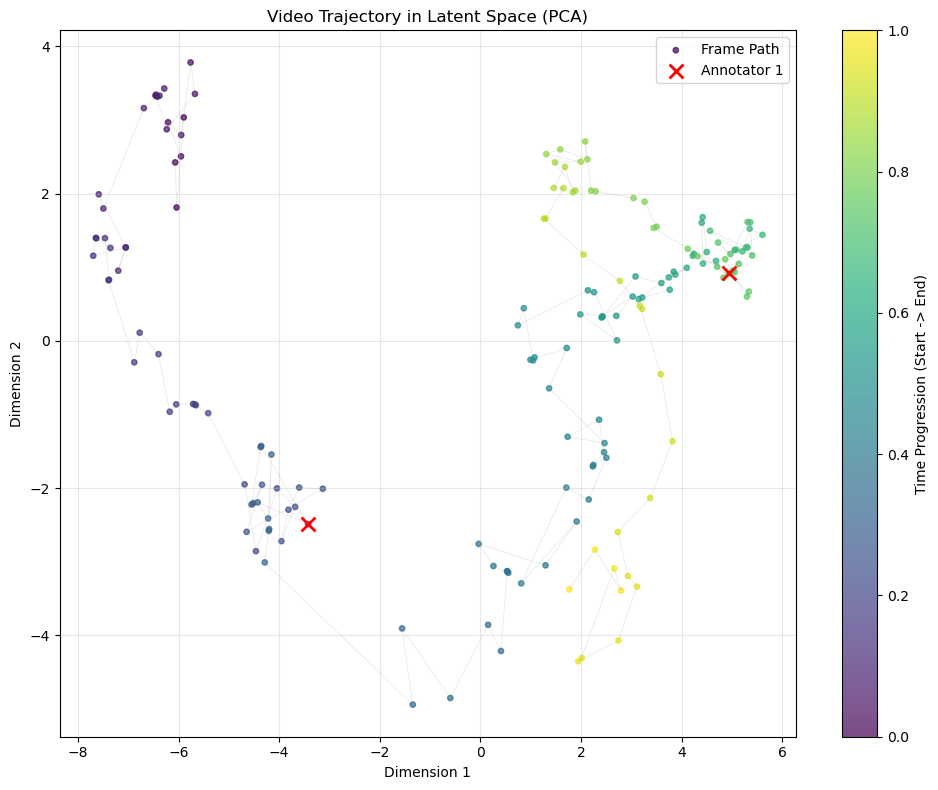

In [10]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def visualize_embedding_trajectory(embeddings, annot_frames, method='pca'):
    """
    Projects embeddings to 2D and plots the trajectory with time-based coloring.
    
    Args:
        embeddings (List[Tensor] or np.array): The high-dim frame embeddings.
        annot_frames (List[List[int]]): List of lists of frame IDs for annotations.
        method (str): 'pca' (faster, linear) or 'tsne' (better clusters, non-linear).
    """
    # 1. Convert embeddings to numpy if they are tensors
    if hasattr(embeddings[0], 'cpu'):
        # Stack into a single tensor then convert to numpy
        import torch
        if isinstance(embeddings, list):
            data = torch.stack(embeddings).cpu().numpy()
        else:
            data = embeddings.cpu().numpy()
    else:
        data = np.array(embeddings)
        
    # Flatten if dimensions are > 2 (e.g. [N, 1, D] -> [N, D])
    if len(data.shape) > 2:
        data = data.reshape(data.shape[0], -1)

    n_frames = data.shape[0]
    print(f"Projecting {n_frames} frames from {data.shape[1]}D to 2D using {method.upper()}...")

    # 2. Dimensionality Reduction
    if method.lower() == 'tsne':
        reducer = TSNE(n_components=2, perplexity=min(30, n_frames/4), random_state=42, init='pca', learning_rate='auto')
        coords = reducer.fit_transform(data)
    else:
        reducer = PCA(n_components=2)
        coords = reducer.fit_transform(data)

    # 3. Plotting
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Create a time gradient (0 to 1) for coloring
    time_indices = np.linspace(0, 1, n_frames)
    
    # Plot the path (scatter plot with connected lines implied by order if we used plot, 
    # but scatter is better for color gradient)
    sc = ax.scatter(coords[:, 0], coords[:, 1], c=time_indices, cmap='viridis', 
                    s=15, alpha=0.7, label='Frame Path')
    
    # Add a colorbar to show time progression
    cbar = plt.colorbar(sc, ax=ax)
    cbar.set_label('Time Progression (Start -> End)')

    # Optional: Connect points with a faint line to show trajectory clearly
    ax.plot(coords[:, 0], coords[:, 1], c='gray', alpha=0.2, lw=0.5)

    # 4. Mark Boundaries (Ground Truth)
    # Define marker styles/colors for different annotators
    markers = ['x', 'd', '*', '^'] 
    colors = ['red', 'orange', 'magenta', 'black']
    
    for idx, (ids, _) in enumerate(zip(annot_frames, colors)):
        # Ensure ids is a list
        if not isinstance(ids, (list, tuple, np.ndarray)):
            ids = [ids]
            
        annotator_coords = []
        valid_ids = []
        
        for fid in ids:
            if 0 <= fid < n_frames:
                annotator_coords.append(coords[fid])
                valid_ids.append(fid)
        
        if annotator_coords:
            annotator_coords = np.array(annotator_coords)
            ax.scatter(annotator_coords[:, 0], annotator_coords[:, 1], 
                       marker=markers[idx % len(markers)], 
                       c=colors[idx % len(colors)], 
                       s=100, linewidths=2, 
                       label=f'Annotator {idx+1}')

    ax.set_title(f"Video Trajectory in Latent Space ({method.upper()})")
    ax.set_xlabel("Dimension 1")
    ax.set_ylabel("Dimension 2")
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


visualize_embedding_trajectory(embeddings, annots_frames, method='pca')

In [8]:
from scipy.signal import find_peaks

# 1. Ensure data is on CPU and is a numpy array
#    (Assuming 'differences' might be a torch.Tensor on CUDA)
if hasattr(differences, 'cpu'):
    signal = differences.detach().cpu().numpy()
else:
    signal = np.array(differences)

# 2. Flatten if necessary (ensure it's 1D)
signal = signal.flatten()

# 3. Find Peaks
#    height: Minimum value to be considered a peak (filters low-level noise)
#    distance: Min frames between peaks (prevents detecting the same cut twice)
#    prominence: How much a peak stands out relative to the surrounding baseline
peaks, properties = find_peaks(
    signal, 
    #height=0.1,      # Adjust based on your embedding metric (e.g., Cosine vs Euclidean)
    distance=1,      # E.g., assume cuts won't happen closer than 5 frames apart
    prominence=0.01  # Helps ignore "noisy" high areas
)

# Calculate timestamps of the detected boundaries
detected_timestamps = peaks / native_fps
print("Timestamps (seconds):", detected_timestamps)


print(f"Detected {len(peaks)} boundaries at frame indices: {peaks}, Timestamps (s): {detected_timestamps}")

Timestamps (seconds): [2.33333333 2.6        2.7        3.16666667 3.46666667 3.63333333
 3.73333333 3.83333333 4.2        4.4        4.56666667 4.66666667
 4.86666667]
Detected 13 boundaries at frame indices: [ 70  78  81  95 104 109 112 115 126 132 137 140 146], Timestamps (s): [2.33333333 2.6        2.7        3.16666667 3.46666667 3.63333333
 3.73333333 3.83333333 4.2        4.4        4.56666667 4.66666667
 4.86666667]


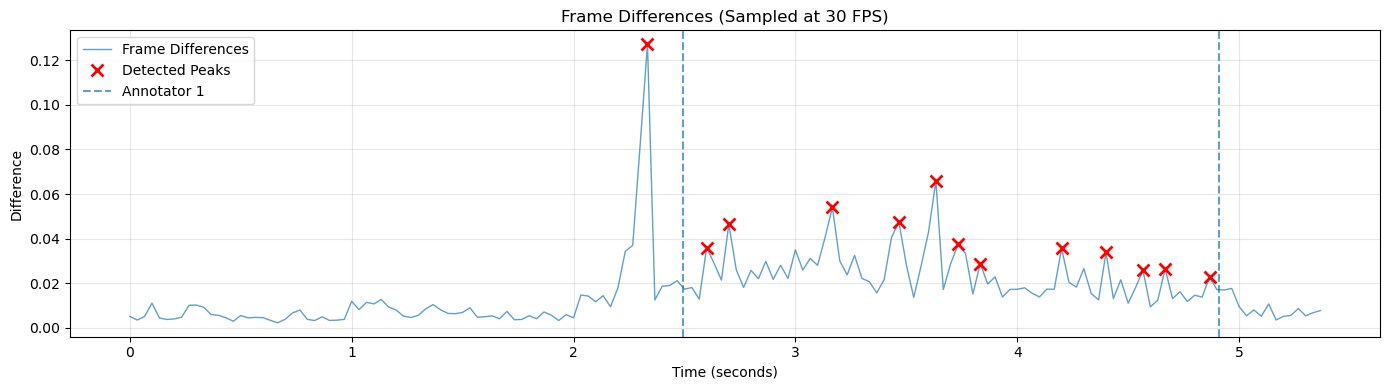

In [9]:
analyzer.plot_differences_with_annotations(differences, native_fps,
                                            annotations=annots_timestamps,
                                            peaks=peaks,
                                            save_path=None)

VIDEOPRISM

In [4]:
import os
import glob
import numpy as np
import mediapy
from PIL import Image

def read_and_preprocess_frames_from_folder(
    folder_path: str, 
    target_num_frames: int, 
    target_frame_size: tuple[int, int] = (288, 288), 
    overlap: float = 0.0
):
  """
  Reads images from a folder, resizes them, and splits them into batches with optional overlap.
  
  Args:
      folder_path (str): Path to folder containing image sequences.
      target_num_frames (int): Number of frames per batch.
      target_frame_size (tuple): (height, width) for resizing. Defaults to (288, 288).
      overlap (float): Fraction of overlap between batches [0.0, 1.0). 
                       0.0 = distinct batches, 0.5 = 50% overlap.
  
  Returns:
      np.ndarray: A numpy array of shape (num_batches, target_num_frames, H, W, 3).
  """
  
  # Validate overlap
  if not (0.0 <= overlap < 1.0):
      raise ValueError("Overlap must be >= 0.0 and < 1.0")

  # 1. Find all image files
  extensions = ['*.jpg', '*.jpeg', '*.png']
  image_paths = []
  
  for ext in extensions:
      image_paths.extend(glob.glob(os.path.join(folder_path, ext)))
  
  # 2. Sort naturally to ensure temporal order
  image_paths.sort()

  if not image_paths:
      print(f"[WARN] No images found in {folder_path}")
      return np.array([])
      
  if len(image_paths) < target_num_frames:
      print(f"[WARN] Found {len(image_paths)} frames, but need {target_num_frames} for a batch.")
      return np.array([])

  print(f"Folder: {os.path.basename(folder_path)} | Loading {len(image_paths)} frames...")

  # 3. Load and Resize ALL frames into a continuous buffer
  buffer_frames = []
  target_height, target_width = target_frame_size

  for path in image_paths:
      try:
          img = Image.open(path).convert("RGB")
          img = img.resize((target_width, target_height), Image.Resampling.BILINEAR)
          buffer_frames.append(np.array(img))
      except Exception as e:
          print(f"[ERROR] Could not load {path}: {e}")

  buffer_frames = np.array(buffer_frames) # Shape: (Total_Frames, H, W, 3)

  print(f"Loaded and resized {len(buffer_frames)} frames to {target_frame_size}.")

  # 4. Create Batches using Sliding Window
  stride = int(target_num_frames * (1 - overlap))
  stride = max(1, stride) # Prevent infinite loop if overlap is high/frames low
  
  batched_frames = []
  num_frames = len(buffer_frames)
  
  for start_idx in range(0, num_frames, stride):
      end_idx = start_idx + target_num_frames
      
      if end_idx > num_frames:
          break
          
      batch = buffer_frames[start_idx:end_idx]
      batched_frames.append(batch)

  if not batched_frames:
      return np.array([])

  # Stack into final shape: (Num_Batches, Sequence_Length, H, W, C)
  batched_frames = np.stack(batched_frames)

  # 5. Normalize pixel values to [0.0, 1.0]
  batched_frames = mediapy.to_float01(batched_frames)

  print(f"Generated {len(batched_frames)} batches with stride {stride}.")
  
  return batched_frames

In [5]:
TARGET_FPS = None
#VIDEO_PATH = "kinetics-dataset/k400/val/-15OAjLm520_000006_000016.mp4"
#VIDEO_PATH = "data/TAPOS/images/val/-20rr-TvsuA_s00015_0_000_6_559"
VIDEO_PATH = "data/TAPOS/images/val/-EfgHYVRUiQ_s00005_0_501_6_206"

all_frames = read_and_preprocess_frames_from_folder(
    VIDEO_PATH, 
    target_num_frames=8, 
)


Folder: -EfgHYVRUiQ_s00005_0_501_6_206 | Loading 171 frames...
Loaded and resized 171 frames to (288, 288).
Generated 21 batches with stride 8.


In [6]:
all_frames.shape

(21, 8, 288, 288, 3)

In [7]:
# @title Load model

import jax
import jax.numpy as jnp
from videoprism import models as vp

MODEL_NAME = 'videoprism_public_v1_large'  # @param ['videoprism_public_v1_base', 'videoprism_public_v1_large'] {allow-input: false}
USE_BFLOAT16 = False  # @param { type: "boolean" }
NUM_FRAMES = 16
FRAME_SIZE = 288

fprop_dtype = jnp.bfloat16 if USE_BFLOAT16 else None
flax_model = vp.get_model(MODEL_NAME, fprop_dtype=fprop_dtype)
loaded_state = vp.load_pretrained_weights(MODEL_NAME)


@jax.jit
def forward_fn(inputs, train=False):
  return flax_model.apply(loaded_state, inputs, train=train)

In [8]:
print(jax.devices())

# It should output something like: [GpuDevice(id=0, process_index=0)]
# If it still says CpuDevice, the installation didn't link correctly.

[CudaDevice(id=0)]


In [48]:
for frame_batch in all_frames:
  frames = frame_batch  # Shape: (NUM_FRAMES, H, W, 3)
  break  # Just take the first batch for this demo
frames = jnp.asarray(frames[None, ...])  # Add batch dimension.
if USE_BFLOAT16:
  frames = frames.astype(jnp.bfloat16)
print(f'Input shape: {frames.shape} [type: {frames.dtype}]')

embeddings, _ = forward_fn(frames)
print(f'Encoded embedding shape: {embeddings.shape} [type: {embeddings.dtype}]')


Input shape: (1, 8, 288, 288, 3) [type: float32]


: 

: 

: 

In [9]:
all_embeddings = []
for frame_batch in all_frames:
    frames = frame_batch  # Shape: (NUM_FRAMES, H, W, 3)
    frames = jnp.asarray(frames[None, ...])  # Add batch dimension.
    if USE_BFLOAT16:
        frames = frames.astype(jnp.bfloat16)
    print(f'Input shape: {frames.shape} [type: {frames.dtype}]')

    embeddings, _ = forward_fn(frames)
    print(f'Encoded embedding shape: {embeddings.shape} [type: {embeddings.dtype}]')
    all_embeddings.append(embeddings)

Input shape: (1, 8, 288, 288, 3) [type: float32]


W0121 11:04:08.726851 1778193 gemm_fusion_autotuner.cc:1193] Compiling 188 configs for 14 fusions on a single thread.


Encoded embedding shape: (1, 2048, 1024) [type: float32]
Input shape: (1, 8, 288, 288, 3) [type: float32]
Encoded embedding shape: (1, 2048, 1024) [type: float32]
Input shape: (1, 8, 288, 288, 3) [type: float32]
Encoded embedding shape: (1, 2048, 1024) [type: float32]
Input shape: (1, 8, 288, 288, 3) [type: float32]
Encoded embedding shape: (1, 2048, 1024) [type: float32]
Input shape: (1, 8, 288, 288, 3) [type: float32]
Encoded embedding shape: (1, 2048, 1024) [type: float32]
Input shape: (1, 8, 288, 288, 3) [type: float32]
Encoded embedding shape: (1, 2048, 1024) [type: float32]
Input shape: (1, 8, 288, 288, 3) [type: float32]
Encoded embedding shape: (1, 2048, 1024) [type: float32]
Input shape: (1, 8, 288, 288, 3) [type: float32]
Encoded embedding shape: (1, 2048, 1024) [type: float32]
Input shape: (1, 8, 288, 288, 3) [type: float32]
Encoded embedding shape: (1, 2048, 1024) [type: float32]
Input shape: (1, 8, 288, 288, 3) [type: float32]
Encoded embedding shape: (1, 2048, 1024) [type

In [10]:
analyzer = SigLIPVideoDifferenceAnalyzer()

Loading SigLIP model: google/siglip-so400m-patch14-384


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Model loaded on cuda


In [10]:
import torch
import numpy as np

# 1. Consolidate the JAX list into one JAX array
# This happens on the GPU (if available)
jax_array = jnp.concatenate(all_embeddings, axis=0)

# 2. Move to CPU and convert to NumPy
# Note: This is necessary because JAX and Torch don't share memory directly by default
numpy_array = np.array(jax_array)

# 3. Convert to PyTorch Tensor
torch_tensor = torch.from_numpy(numpy_array)

print(f"Torch Tensor shape: {torch_tensor.shape} [dtype: {torch_tensor.dtype}]")

Torch Tensor shape: torch.Size([21, 2048, 1024]) [dtype: torch.float32]


In [11]:
pooled_embeddings = torch_tensor.mean(dim=1)
print(f"Pooled Embeddings shape: {pooled_embeddings.shape} [dtype: {pooled_embeddings.dtype}]")

differences = analyzer.calculate_differences(pooled_embeddings)


Pooled Embeddings shape: torch.Size([21, 1024]) [dtype: torch.float32]


In [12]:
gt_annotation_path ="data/TAPOS/tapos_gt_val.pkl"

In [13]:
print("differences:", differences, "shape:", differences.shape)

differences: [0.00156963 0.00197816 0.00119591 0.00235993 0.00264406 0.00225061
 0.00578678 0.00258225 0.0041309  0.00215018 0.00179666 0.0007326
 0.00162172 0.00225359 0.00108933 0.0026511  0.00327915 0.00179696
 0.00230575 0.00515747] shape: (20,)


In [16]:
annots_frames = load_gt_annotation_frame(gt_annotation_path, VIDEO_PATH)

Video ID: -EfgHYVRUiQ_s00005_0_501_6_206
Loaded annotations for 1755 videos.
Found entry for video: {'num_frames': 171, 'path_video': '/workspace/GEBD/data/TAPOS/videos/-EfgHYVRUiQ.mp4', 'fps': 29.97370727432077, 'video_duration': 5.705, 'path_frame': '/workspace/GEBD/data/TAPOS/images/val/-EfgHYVRUiQ_s00005_0_501_6_206', 'f1_consis': [1.0], 'f1_consis_avg': 1.0, 'substages_myframeidx': [[50, 132]], 'substages_timestamps': [[1.6681286549707603, 4.403859649122807]]}


In [17]:
all_frames.shape

(21, 8, 288, 288, 3)

In [18]:
plotframes = [f[7] for f in all_frames[1:]]

In [19]:
len(plotframes)

20

In [20]:
annots_frames

[[50, 132]]

In [21]:
annots_frames = [[(x / 8)-2 for x in frame] for frame in annots_frames]

In [22]:
annots_frames

[[4.25, 14.5]]

In [23]:
len(plotframes), len(differences)

(20, 20)

In [26]:
visualize_video_ipywidgets(plotframes, differences, annot_frames=annots_frames)

/tmp/ipykernel_1778193/3840006267.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10')


interactive(children=(IntSlider(value=0, description='Frame:', layout=Layout(width='100%'), max=19), Output())…